In [1]:
%run ./Definitions.ipynb

2020-01-07 21:46:06.507968
thunder  Tue Jan  7 21:46:06 2020
[0] GeForce GTX 1080 Ti | 39'C,   0 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 24'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K


Tue Jan  7 21:46:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   39C    P2    56W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Loading train data to use in Random Forest - union ground truth

In [11]:
tts_path = DATA_dir+'TrainTestVal/'
enc_df = pd.read_pickle(DATA_dir + 'enc_df.pkl')
y_train_df = pd.read_pickle(tts_path + 'yu_train.pkl')
y_val_df = pd.read_pickle(tts_path + 'yu_val.pkl')
y_test_df = pd.read_pickle(tts_path + 'yu_test.pkl')

#### Converting the labels to list and assign 0 label to non glaucoma (2 or 3 mismatch)

In [12]:
y_train = y_train_df['ClassLabel'].tolist()
y_val = y_val_df['ClassLabel'].tolist()
y_test = y_test_df['ClassLabel'].tolist()

for i in range(len(y_train)):
    if(y_train[i] != 0):
        y_train[i] = 1
        
for i in range(len(y_val)):
    if(y_val[i] != 0):
        y_val[i] = 1

for i in range(len(y_test)):
    if(y_test[i] != 0):
        y_test[i] = 1

In [13]:
indices_train = np.load(tts_path + 'indices_train.npy')
indices_val = np.load(tts_path + 'indices_val.npy')
indices_test = np.load(tts_path + 'indices_test.npy')

In [14]:
enc_df.shape, len(y_train), len(y_val)

((85730, 6251), 51438, 17146)

## Class Distribution

#### No. of Glaucoma and non Glaucoma patients in training set

In [7]:
n_NG = 0
n_G = 0

for i in range(len(y_train)):
    if(y_train[i] == 1):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 1358
No. of non-Glaucoma patients in training set: 50080


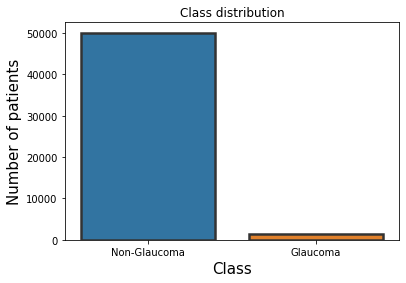

In [8]:
import seaborn as sns

class_name = ['Non-Glaucoma', 'Glaucoma']
count = [n_NG, n_G]
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of patients', fontsize=15)
plt.title('Class distribution')
plt.show()

## Assigning class weight for imbalance data set to use in Random forest classifier

In [52]:
class_weight = dict({0:1, 1:35})

## Feature Reduction and Saving Dataframe with reduced features

In [10]:
# cols2rem = ['87-','92-','135-','2227-','4689-','5181-','5326-','5327-','5945-','6119-','6148-','20002-','20008-','20009-','20010-','20011','20013-',
#             '20014-','40001-','40002-','41078-','41080-','41082-','41083-','41084-','41096-','41101-','41142-','41202-','41204-',
#             '41200-','41210-']

# # len(cols2rem) # 13
# remove_df  = enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[0])]
# for i in range(1,len(cols2rem)):
#     remove_df = remove_df.join(enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[i])])
    
# new_enc_df = enc_df.drop(remove_df.columns, axis=1)
# new_enc_df.shape

### Spliting new_enc_df to train test val as per the indices

In [11]:
# meta_train = []
# meta_val = []
# meta_test = []

# for i in range(len(indices_train)):
#     meta_train.append(new_enc_df.iloc[indices_train[i]])
    
# for i in range(len(indices_val)):
#     meta_val.append(new_enc_df.iloc[indices_val[i]])
#     meta_test.append(new_enc_df.iloc[indices_test[i]])

# meta_train_arr = np.asarray(meta_train)
# meta_val_arr = np.asarray(meta_val)
# meta_test_arr = np.asarray(meta_test)

# meta_train_df = pd.DataFrame(meta_train_arr,columns = new_enc_df.columns)
# meta_val_df = pd.DataFrame(meta_val_arr,columns = new_enc_df.columns)
# meta_test_df = pd.DataFrame(meta_test_arr,columns = new_enc_df.columns)

In [12]:
# #SAVE - DONE
# meta_train_df.to_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
# meta_val_df.to_pickle(tts_path + 'reducedfeatures_meta_val.pkl')
# meta_test_df.to_pickle(tts_path + 'reducedfeatures_meta_test.pkl')

### Loading Reduced Features Encodeded Metadata - Train and Validation

In [53]:
meta_train_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
meta_val_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_val.pkl')

meta_train_df.shape, meta_val_df.shape, len(y_train), len(y_val)

((51438, 4898), (17146, 4898), 51438, 17146)

## RandomForestClassifier for Feature Importance

#### 1. Without class weights - everything is classified as majority class - High accuracy but 0 precision and recall

In [14]:
# # Random forest classifier
rfc_all = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
rfc_all.fit(meta_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [15]:
# # Saving -- DONE !!
# from sklearn.externals import joblib
# joblib.dump(rfc_all, tts_path + 'RandomForest_allfeat_union.sav')

In [16]:
# rfc_all = joblib.load(tts_path + 'RandomForest_allfeat_union.sav')

#### 2. With class weights - giving higher weight to minority class

In [17]:
# # rfc_all_cw = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)

# rfc_all_cw = RandomForestClassifier(bootstrap=True,
#                                     class_weight=class_weight, criterion='gini',
#                                     max_depth=8, max_features='auto', max_leaf_nodes=None,
#                                     min_impurity_decrease=0.0, min_impurity_split=None,
#                                     min_samples_leaf=4, min_samples_split=10,
#                                     min_weight_fraction_leaf=0.0, n_estimators=300,
#                                     n_jobs=-1, oob_score=True,
#                                     verbose=0, warm_start=False)

In [18]:
# rfc_all_cw.fit(meta_train_df, y_train)

### Feature Dictionaries

In [54]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [20]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_all, meta_train_df)

In [21]:
pd.options.display.max_colwidth = 100

fi_red = get_imp_features(50)
display_all(fi_red)

,Features,Importance
0,"Intra-ocular pressure, corneal-compensated (right)",0.014278
1,Intra-ocular pressure device ID (left),0.011971
2,"Intra-ocular pressure, Goldmann-correlated (left)",0.011143
3,"Intra-ocular pressure, Goldmann-correlated (right)",0.010521
4,Duration visual-acuity screen displayed (right),0.006991
5,Taking other prescription medications,0.006498
6,Age cataract diagnosed,0.004261
7,Time since interview start at which blood pressure screen(s) shown,0.004218
8,Corneal hysteresis (right),0.004204
9,Age when attended assessment centre,0.003910


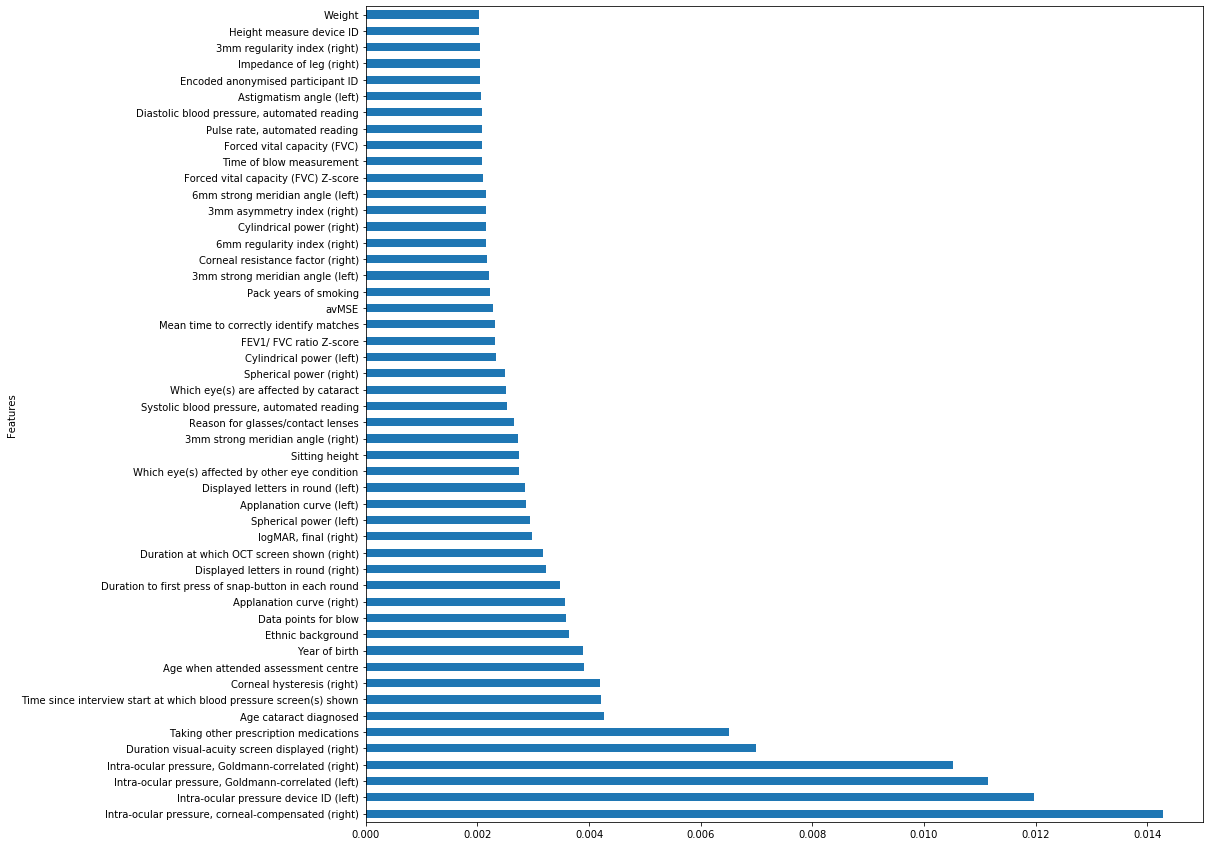

In [22]:
def plot_fi(finew):
    return finew.plot('Features','Importance','barh',figsize=(15,15),legend=False)

plot_fi(fi_red)

## Creating Dataframe containing important features

In [23]:
# Getting feature from feature description
feat_to_keep = fi_red[fi_red.Importance>0.0022].Features
featval_to_keep = []
for i in range(len(feat_to_keep)):
    for feat, desc in feat_unique_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if desc == feat_to_keep[i]:
            featval_to_keep.append(feat)
            break
            
len(featval_to_keep)

34

In [24]:
meta_train_df.shape, meta_val_df.shape

((51438, 4898), (17146, 4898))

In [25]:
redtrain_df = meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redtrain_df = redtrain_df.join(meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[i])])
    
redtrain_df.shape

(51438, 296)

In [26]:
redval_df = meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redval_df = redval_df.join(meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[i])])
    
redval_df.shape

(17146, 296)

### Saving the dataframe

In [27]:
# redtrain_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df.pkl')
# redval_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df.pkl')

### Loading the dataframe

In [28]:
# # LOAD
# redtrain_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df.pkl')
# redval_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df.pkl')
# redtrain_df.shape, redval_df.shape

#### without class_weight

In [29]:
rfc_red = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
rfc_red.fit(redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [30]:
# # Saving -- DONE !!
# from sklearn.externals import joblib
# joblib.dump(rfc_red, tts_path + 'RandomForest_redfeat_union.sav')

#### with class weight

In [31]:
# rfc_red_cw = RandomForestClassifier(bootstrap=True,
#                                     class_weight=class_weight, criterion='gini',
#                                     max_depth=8, max_features='auto', max_leaf_nodes=None,
#                                     min_impurity_decrease=0.0, min_impurity_split=None,
#                                     min_samples_leaf=4, min_samples_split=10,
#                                     min_weight_fraction_leaf=0.0, n_estimators=300,
#                                     n_jobs=-1, oob_score=True,
#                                     verbose=0, warm_start=False)

# rfc_red_cw.fit(redtrain_df, y_train)

### Loading Reduced features random forest

In [32]:
# rfc_red = joblib.load(tts_path + 'RandomForest_redfeat.sav')

In [33]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [34]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_red, redtrain_df)
fi_red = get_imp_features(40)
display_all(fi_red)

,Features,Importance
0,"Intra-ocular pressure, Goldmann-correlated (left)",0.029517
1,"Intra-ocular pressure, corneal-compensated (right)",0.027055
2,"Intra-ocular pressure, Goldmann-correlated (right)",0.024462
3,Duration visual-acuity screen displayed (right),0.020581
4,Time since interview start at which blood pressure screen(s) shown,0.017818
5,Corneal hysteresis (right),0.017101
6,Data points for blow,0.016973
7,"Systolic blood pressure, automated reading",0.015427
8,Applanation curve (left),0.015056
9,Sitting height,0.014930


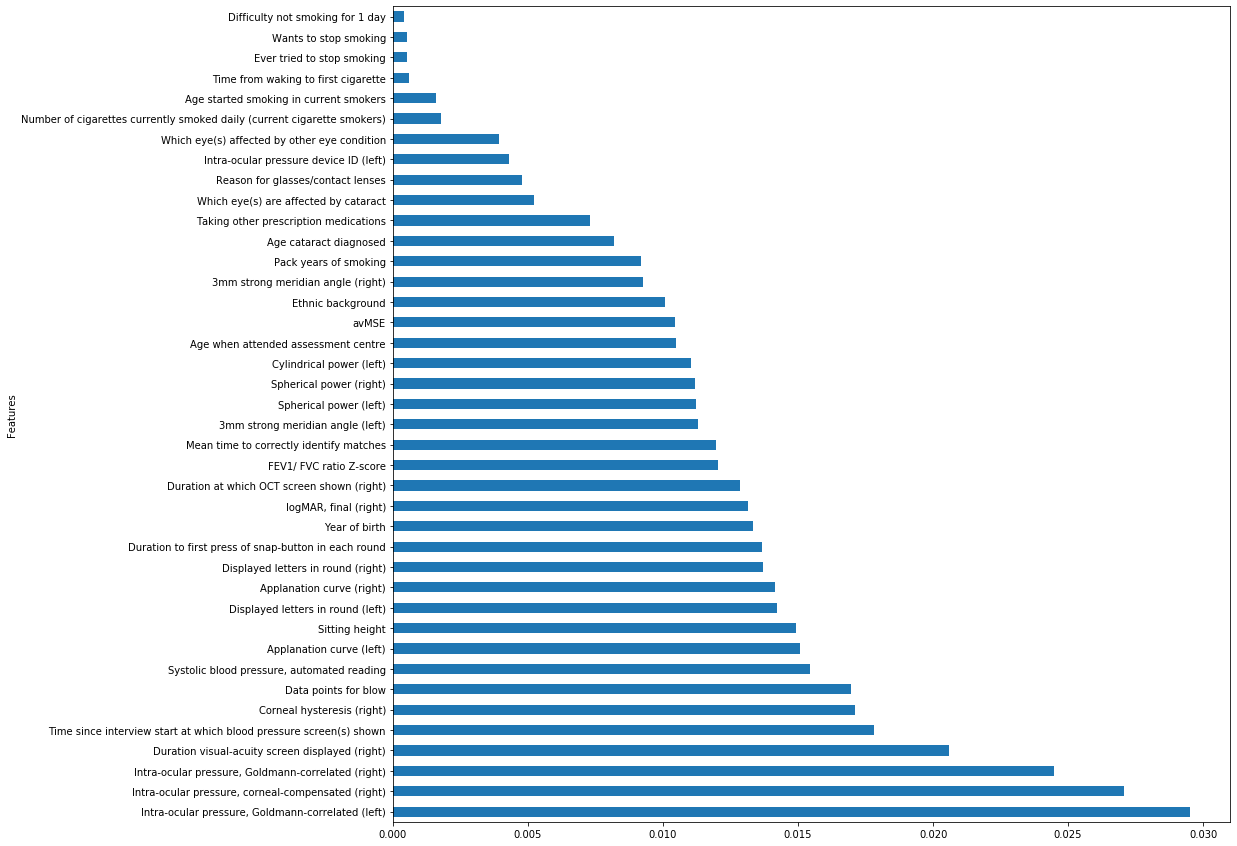

In [35]:
plot_fi(fi_red)

## Compare The Accuracy Of Full Feature Classifier To Limited Feature Classifier


In [36]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

# Full Featured Classifier To The Test Data
y_pred = rfc_all.predict(meta_val_df)
y_important_pred = rfc_red.predict(redval_df)

#### F1 score

In [37]:
# 40 features
f1_score(y_val, y_pred) , f1_score(y_val, y_important_pred)

(0.004347826086956523, 0.017204301075268817)

#### Accuracy score

In [38]:
accuracy_score(y_val, y_pred) , accuracy_score(y_val, y_important_pred)

(0.9732882304910766, 0.9733465531319259)

#### Recall score

In [39]:
recall_score(y_val, y_pred) , recall_score(y_val, y_important_pred)

(0.002178649237472767, 0.008714596949891068)

#### Precision score

In [40]:
precision_score(y_val, y_pred) , precision_score(y_val, y_important_pred)

(1.0, 0.6666666666666666)

#### classification_report

In [41]:
print(classification_report(y_val, y_pred) ,"\n\n", classification_report(y_val, y_important_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     16687
           1       1.00      0.00      0.00       459

    accuracy                           0.97     17146
   macro avg       0.99      0.50      0.50     17146
weighted avg       0.97      0.97      0.96     17146
 

               precision    recall  f1-score   support

           0       0.97      1.00      0.99     16687
           1       0.67      0.01      0.02       459

    accuracy                           0.97     17146
   macro avg       0.82      0.50      0.50     17146
weighted avg       0.97      0.97      0.96     17146



#### Confusion matrix

In [42]:
# tn, fp, fn, tp
print(confusion_matrix(y_val, y_pred) ,"\n\n", confusion_matrix(y_val, y_important_pred))

[[16687     0]
 [  458     1]] 

 [[16685     2]
 [  455     4]]


Healthy Patients - correctly identified (True Negatives):  16687 1.0
Healthy Patients - predicted to have glaucoma (False Positives):  0 0.0
Glaucoma Patients - predicted healthy (False Negatives):  458 0.9978213507625272
Glaucoma Patients - correctly identified (True Positives):  1 0.002178649237472767

Total Glaucoma patients:  459 1.0
Total Healthy patients:  16687 1.0


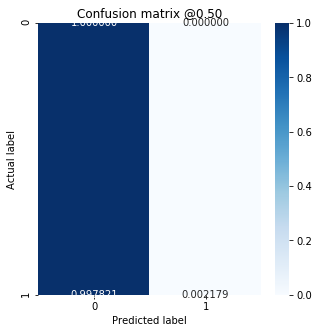

In [43]:
plot_cm(y_val, y_pred)